In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
!pip install control
from ipywidgets import interact, FloatSlider
from control import tf, forced_response
import numpy as np
from numpy import linspace, pi, absolute
from matplotlib import pyplot as plt
from math import e, log, sqrt
import pandas as pd
plt.style.use("seaborn")

In [2]:
alpha = 0.9
beta = 20
delta = 0.4
r0 = pi/2

In [3]:
def rise_time(y: np.ndarray, t: np.ndarray, ss: float) -> float:
  """Computes rise time for the given response"""
  ss = 90
  y0 = 0.1*ss;
  y1 = 0.9*ss;
  t0 = None
  t1 = None

  for i, val in enumerate(y):
    if t0 is None and (val > y0):
      t0 = t[i]
    if t1 is None and (val > y1):
      t1 = t[i]
    
  return t1-t0

In [4]:
def overshoot(y: np.ndarray, ss: float) -> float:
    """Computes percentage overshoot for given response"""
    max_val = y.max()
    percentage_overshoot = ((max_val - ss) / ss) * 100
    return percentage_overshoot

In [5]:
def damping_coef(M_p: float) -> float:
    """Returns the damping coefficient for the given overshoot (%)"""
    overshoot = M_p / 100
    ln_os = log(overshoot, e)
    coef = -ln_os / (sqrt(pi ** 2 + ln_os ** 2))
    return coef

In [6]:
def canard_roll(K_p, K_i, K_d, time_range, reference):
    """Returns the canard angle and roll angle of the rocket's roll control system"""
    G = tf([beta*K_p, beta*K_i],[1, alpha+beta*K_d, delta+beta*K_p, beta*K_i])
    canard_angle_tf = tf([1, alpha, delta], [beta]) * G
    _, y = forced_response(G, time_range, reference)
    _, u = forced_response(canard_angle_tf, time_range, reference)
    y *= 180 / pi
    u *= 180 / pi
    return u, y

In [7]:
Ki_slider = FloatSlider(min=0, max=0.5, value=0.25, step=0.01)
Kp_slider = FloatSlider(min=0, max=1.75, value=0.5, step=0.01)
Kd_slider = FloatSlider(min=0, max=2, value=0.5, step=0.01)

@interact(K_p = Kp_slider , K_d = Kd_slider, K_i = Ki_slider)
def display_system(K_p, K_i, K_d):
    
    time_range = linspace(0, 10, 100)
    R = np.full_like(time_range, r0)
    u, y = canard_roll(K_p, K_i, K_d, time_range, R)

    _, (axl, axr) = plt.subplots(1, 2, figsize=(10, 3.5))
    axl.set_xlabel("Time (s)")
    axl.set_ylabel("Roll angle (°)")
    axr.set_xlabel("Time (s)")
    axr.set_ylabel("Canard angle (°)")
    axl.axhline(y=90, ls = '--', color = "gray")
    axl.plot(time_range, y)
    axr.plot(time_range, u)
    M_p = overshoot(y, 90)
    t_r = rise_time(y, time_range, 90)
    e_ss = 90 - y[-1]
    zeta = damping_coef(M_p) if M_p > 0 else 0.0
    print(f"e_ss = {absolute(e_ss):.2f}")
    print(f"M_p = {M_p:.1f} %")
    print(f"t_r = {t_r:.2f} s")
    print(f"zeta = {zeta:.2}")

interactive(children=(FloatSlider(value=0.5, description='K_p', max=1.75, step=0.01), FloatSlider(value=0.25, …

#Realised PD Controller

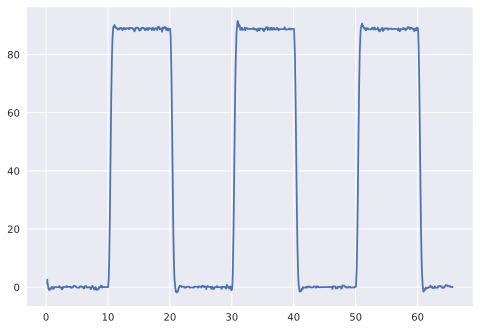

In [8]:
pd_cont = pd.read_csv("pd_controller_data.csv")
plt.plot(pd_cont['time'], pd_cont['roll_angle']);

Worst case overshoot appears on the second pulse, so this will be analysed:

e_ss = 1.21
M_p = 1.7 %
t_r = 0.48 s
zeta = 0.79


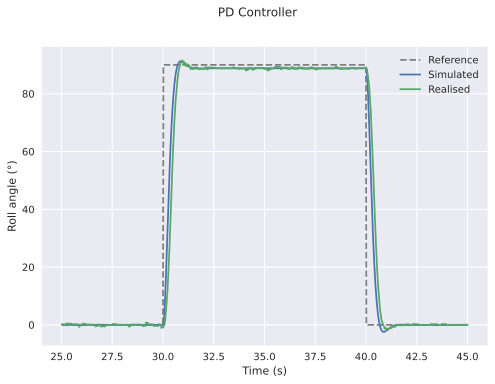

In [9]:
pd_pulse = pd_cont[(pd_cont['time'] >= 25) & (pd_cont['time'] <= 45)]

M_p = overshoot(pd_pulse['roll_angle'], 90)
t_r = rise_time(pd_pulse['roll_angle'], pd_pulse['time'].to_numpy(), 90)
ss = pd_pulse[(pd_pulse['time'] >= 32.5) & (pd_pulse['time'] <= 40)]['roll_angle'].mean()
e_ss = 90 - ss
zeta = damping_coef(M_p) if M_p > 0 else 0.0

_, roll = canard_roll(1.5, 0, 0.37, pd_pulse['time'].round(2), pd_pulse['setpoint'] * pi / 180)

fig, ax = plt.subplots()

ax.plot(pd_pulse['time'], pd_pulse['setpoint'], '--', color="gray", label="Reference")
ax.plot(pd_pulse['time'], roll, label="Simulated")
ax.plot(pd_pulse['time'], pd_pulse['roll_angle'], label="Realised");

ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Roll angle (°)")
fig.savefig("pd.svg")
fig.suptitle("PD Controller")

print(f"e_ss = {absolute(e_ss):.2f}")
print(f"M_p = {M_p:.1f} %")
print(f"t_r = {t_r:.2f} s")
print(f"zeta = {zeta:.2}")

#Realised PID Controller

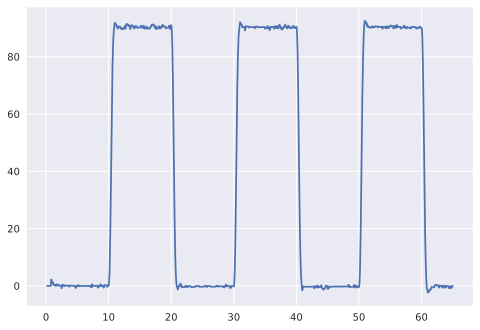

In [10]:
pid_cont = pd.read_csv("pid_controller_data.csv")
plt.plot(pid_cont['time'], pid_cont['roll_angle']);

Worst-case appears to be the final pulse:

e_ss = 0.34
M_p = 2.8 %
t_r = 0.46 s
zeta = 0.75


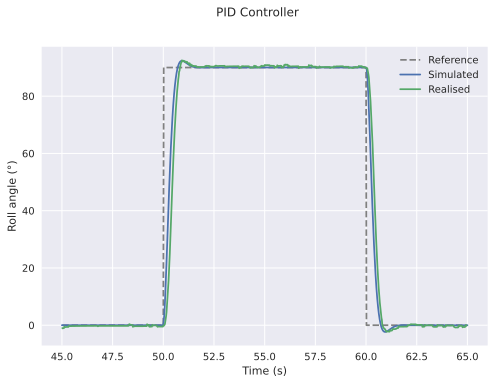

In [11]:
pid_pulse = pid_cont[(pid_cont['time'] >= 45) & (pid_cont['time'] <= 65)]

M_p = overshoot(pid_pulse['roll_angle'], 90)
t_r = rise_time(pid_pulse['roll_angle'], pid_pulse['time'].to_numpy(), 90)
ss = pid_pulse[(pid_pulse['time'] >= 52.5) & (pid_pulse['time'] <= 60)]['roll_angle'].mean()
e_ss = 90 - ss
zeta = damping_coef(M_p) if M_p > 0 else 0.0

time_range = np.linspace(45, 65, 500)
reference = [r0 if 50 <= t <= 60 else 0 for t in time_range]
_, roll = canard_roll(1.34, 0.07, 0.35, time_range, reference)

fig, ax = plt.subplots()

ax.plot(pid_pulse['time'], pid_pulse['setpoint'], '--', color="gray", label="Reference")
ax.plot(time_range, roll, label="Simulated")
ax.plot(pid_pulse['time'], pid_pulse['roll_angle'], label="Realised");

ax.set_xlabel("Time (s)")
ax.set_ylabel("Roll angle (°)")
ax.legend()
fig.savefig("pid.svg")
fig.suptitle("PID Controller")


print(f"e_ss = {absolute(e_ss):.2f}")
print(f"M_p = {M_p:.1f} %")
print(f"t_r = {t_r:.2f} s")
print(f"zeta = {zeta:.2}")

#Realised Minimised Canard Angle Controller

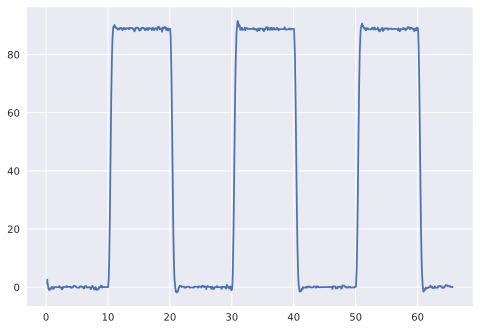

In [12]:
canard_cont = pd.read_csv("minimised_canard_data.csv")
plt.plot(pd_cont['time'], pd_cont['roll_angle']);

Worst-case appears to be middle pulse:

e_ss = 0.33
M_p = 4.5 %
t_r = 0.60 s
zeta = 0.7


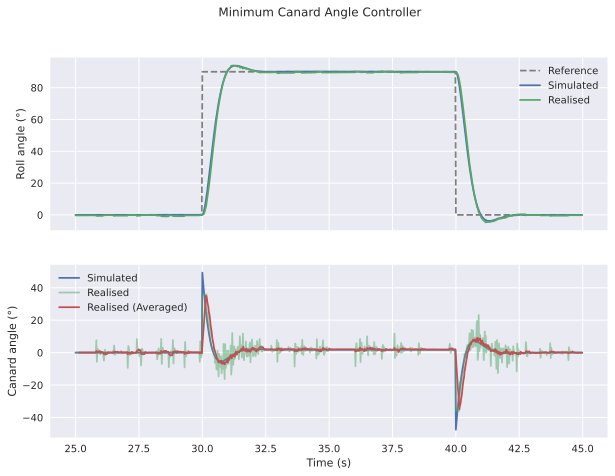

In [13]:
canard_pulse = canard_cont[(canard_cont['time'] >= 25) & (canard_cont['time'] <= 45)]

M_p = overshoot(canard_pulse['roll_angle'], 90)
t_r = rise_time(canard_pulse['roll_angle'], canard_pulse['time'].to_numpy(), 90)
ss = canard_pulse[(canard_pulse['time'] >= 32.5) & (canard_pulse['time'] <= 40)]['roll_angle'].mean()
e_ss = 90 - ss
zeta = damping_coef(M_p) if M_p > 0 else 0.0

canard, roll = canard_roll(0.57, 0.05, 0.2, canard_pulse['time'].round(2), canard_pulse['setpoint'] * pi / 180)

fig, (axt, axb) = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)

axt.plot(canard_pulse['time'], canard_pulse['setpoint'], '--', color="gray", label="Reference")
axt.plot(canard_pulse['time'], roll, label="Simulated")
axt.plot(canard_pulse['time'], canard_pulse['roll_angle'], label="Realised")

axb.plot(canard_pulse['time'], canard, label="Simulated")
axb.plot(canard_pulse['time'], canard_pulse['u_cmd'], label="Realised", alpha=0.5)
axb.plot(canard_pulse['time'], canard_pulse['u_cmd'].rolling(8).mean(), label="Realised (Averaged)")

axb.set_xlabel("Time (s)")
axb.set_ylabel("Canard angle (°)")
axt.set_ylabel("Roll angle (°)")
axt.legend()
axb.legend()

fig.savefig("canard.svg")
fig.suptitle("Minimum Canard Angle Controller")

print(f"e_ss = {absolute(e_ss):.2f}")
print(f"M_p = {M_p:.1f} %")
print(f"t_r = {t_r:.2f} s")
print(f"zeta = {zeta:.2}")